<a href="https://colab.research.google.com/github/masalha-alaa/cifar10-keras/blob/master/cifar10_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from enum import Enum
import sys

In [ ]:
SEED = 42

CUSTOM_MODEL_NAME = 'custom_model'
PRETRAINED_MODEL_NAME = 'pretrained_model'

class ModelType(Enum):    
    CUSTOM_MODEL = 0
    PRETRAINED_MODEL = 1

In [ ]:
model_type_arg = sys.argv[1]
if model_type_arg:
    print('Received arguments.')
    MODEL_TYPE = ModelType.CUSTOM_MODEL if model_type_arg == 'custom' else ModelType.PRETRAINED_MODEL
else:
    # Choose:
    MODEL_TYPE = ModelType.CUSTOM_MODEL
    # MODEL_TYPE = ModelType.PRETRAINED_MODEL

print(f'Model Type: {model_type_arg}')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Running on GPU')
else:
    print('Running on CPU')

Running on GPU


# Load the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Split to training / test sets (we'll let keras make a validation set automatically from the training set)
x_train, y_train = shuffle(x_train, y_train, random_state=SEED)  # shuffle in unison
x_test, y_test = shuffle(x_test, y_test, random_state=SEED)  # shuffle in unison (not needed for test set but doesn't hurt - maybe we'd want to use part of it as a validation set)
print(f'Classes:')
classes_lbls, classes_cnts = np.unique(y_train, return_counts=True)  # => data is balanced. 5K from each class
NUM_CLASSES = len(classes_lbls)
print(classes_lbls)
print(classes_cnts)

Classes:
[0 1 2 3 4 5 6 7 8 9]
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


In [ ]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def lbl_code_to_class(label):
    return classes.get(label)

def class_to_lbl_code(class_name):
    for k,v in classes.items():
        if v == class_name:
            return k
    return None

# convert codes to class names just for visualization
y_train_lbls, y_test_lbls = np.array(list(map(lbl_code_to_class, y_train.flatten()))), np.array(list(map(lbl_code_to_class, y_test.flatten())))

## Peek at the data

Training data: 50000
Test data: 10000
Image shape: (32, 32, 3), Type: <class 'numpy.ndarray'>, Pixel type: <class 'numpy.uint8'>
Examples:


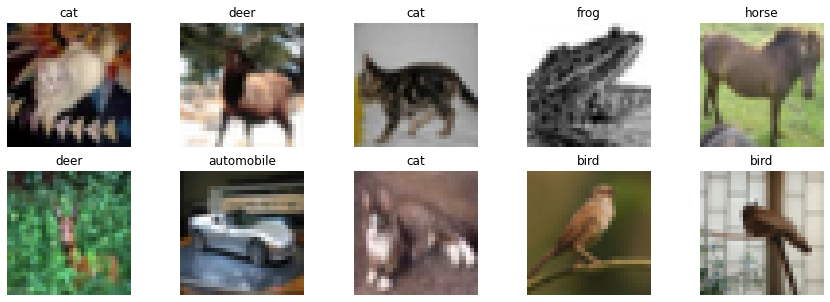

In [ ]:
SAMPLE_IMG_IDS = np.random.randint(0, min(len(y_test), len(y_train)), 10)

print(f'Training data: {len(x_train)}')
print(f'Test data: {len(x_test)}')
IMAGE_SHAPE = x_train[0].shape
IMAGE_SHAPE_2X = (IMAGE_SHAPE[0] * 2, IMAGE_SHAPE[1] * 2, IMAGE_SHAPE[2])
print(f'Image shape: {IMAGE_SHAPE}, Type: {type(x_train[0])}, Pixel type: {type(x_train[0][0][0][0])}')

print('Examples:')
fig = plt.figure(figsize=(15, 5))
fig.tight_layout(pad=1.0)
for i,idx in enumerate(SAMPLE_IMG_IDS):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[idx])
    plt.title(y_train_lbls[idx])
    plt.axis(False)

plt.show()

# Model

## Parameters

In [ ]:
class LossClass(Enum):
    SPARSE_CATEGORICAL = 0,
    CATEGORICAL = 1


BATCH_SIZE = 64
EPOCHS = 65
VAL_SPLIT = 0.15
LOSS = LossClass.CATEGORICAL
# LOSS = LossClass.SPARSE_CATEGORICAL

if LOSS == LossClass.CATEGORICAL:
    loss = keras.losses.CategoricalCrossentropy()
    y_train = to_categorical(y_train, NUM_CLASSES)
    y_test = to_categorical(y_test, NUM_CLASSES)
else:
    loss = keras.losses.SparseCategoricalCrossentropy()
    y_train = tf.reshape(y_train, (-1))
    y_test = tf.reshape(y_test, (-1))

print(f'Output examples:\n{y_test[:5]}')

# Some info about categorical_crossentropy / sparse_categorical_crossentropy etc.:
# https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy
# https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

# note: in both cases, an output layer of size NUM_CLASSES with a softmax should be used.
# see examples:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy#standalone_usage_2
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy#standalone_usage

early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=8,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

Output examples:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Architecture

In [ ]:
def custom_model():
    model = keras.Sequential([
        layers.InputLayer(IMAGE_SHAPE),
        layers.UpSampling2D(),  # it doesn't change the results for this model, but it does improve the pretrained model. so I added it here so the two models are comparable.
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Dropout(0.3),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Dropout(0.3),

        layers.Flatten(),

        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model, keras.optimizers.Adam(learning_rate=0.001), lambda x: x.astype('float32') / 255.0


def pretrained_model():
    vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=IMAGE_SHAPE_2X)  # I think we can omit the input_shape for a dynamic input shape.
                                                                                        # I actually tried it and it worked, although I understand from the docs
                                                                                        # that it should be specified if it's != 224 and include_top is False.
                                                                                        # However, for a clearer summary printing, we need to specify this.
                                                                                        # Otherwise, we would see Nones in the summary.
    # enable training for last block only (determined by try and error)
    # vgg16.trainable = False
    for layer in vgg16.layers[:-4]:
        layer.trainable = False
    
    # print(model.summary())  # enable to see model before modifications

    # replace last layers (we didn't include the top (last) layers, so we must add our own)
    vgg16_ = keras.Sequential()
    vgg16_.add(keras.layers.InputLayer(input_shape=IMAGE_SHAPE))  # Since we added an UpSampling layer before vgg16, the input shape is unknown,
                                                                  # so we specify it here. But it's only necessary for printing the summary before fitting.
                                                                  # Otherwise it's not needed and the shape is inferred.
    vgg16_.add(keras.layers.UpSampling2D())
    vgg16_.add(vgg16)  # add vgg16 as a blackbox
    vgg16_.add(keras.layers.Flatten(name='flatten'))
    vgg16_.add(keras.layers.Dense(4096, activation='relu', name='fc1'))
    vgg16_.add(keras.layers.Dense(4096, activation='relu', name='fc2'))
    vgg16_.add(keras.layers.Dense(10, activation='softmax', name='predictions'))

    return vgg16_, keras.optimizers.Adam(learning_rate=0.0001), tf.keras.applications.vgg16.preprocess_input


if MODEL_TYPE == ModelType.CUSTOM_MODEL:
    model, optim, scaler = custom_model()
else:  # pretrained
    model, optim, scaler = pretrained_model()

x_train, x_test = scaler(x_train), scaler(x_test)
model.summary()
model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_10 (UpSampling (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)      

## Fit model

In [ ]:
if MODEL_TYPE == ModelType.CUSTOM_MODEL:
    # data augmentation
    train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                    validation_split=VAL_SPLIT)
else:  # pretrained
    train_datagen = ImageDataGenerator(validation_split=VAL_SPLIT)

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    subset='training') # set as training data

# train_datagen.fit(train_generator)  # not needed in our case

validation_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    subset='validation') # set as validation data

history = model.fit(
    train_generator,  # x, y, batch size
    validation_data = validation_generator,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback, reduce_lr_callback],
    epochs = EPOCHS,
    verbose = 2)

# Note: we can simply do model.fit(x, y, batch_size=batch, validation_split=VAL_SPLIT, ...) instead of the generator if we don't want data augmentation.
# The reason I'm using a generator in the pretrained model even though I'm not using data augmentation there, is to make it generic with the other model.

model.save(CUSTOM_MODEL_NAME if MODEL_TYPE == ModelType.CUSTOM_MODEL else PRETRAINED_MODEL_NAME)

Epoch 1/65
665/665 - 21s - loss: 1.6874 - accuracy: 0.3828 - val_loss: 1.3989 - val_accuracy: 0.4985
Epoch 2/65
665/665 - 20s - loss: 1.3322 - accuracy: 0.5199 - val_loss: 1.2867 - val_accuracy: 0.5397
Epoch 3/65
665/665 - 20s - loss: 1.1857 - accuracy: 0.5797 - val_loss: 1.1045 - val_accuracy: 0.6039
Epoch 4/65
665/665 - 20s - loss: 1.1078 - accuracy: 0.6065 - val_loss: 1.0949 - val_accuracy: 0.6148
Epoch 5/65
665/665 - 20s - loss: 1.0525 - accuracy: 0.6264 - val_loss: 1.0076 - val_accuracy: 0.6453
Epoch 6/65
665/665 - 19s - loss: 0.9978 - accuracy: 0.6488 - val_loss: 0.9035 - val_accuracy: 0.6803
Epoch 7/65
665/665 - 20s - loss: 0.9597 - accuracy: 0.6607 - val_loss: 0.8269 - val_accuracy: 0.7133
Epoch 8/65
665/665 - 20s - loss: 0.9291 - accuracy: 0.6735 - val_loss: 0.8787 - val_accuracy: 0.6896
Epoch 9/65
665/665 - 19s - loss: 0.9025 - accuracy: 0.6838 - val_loss: 0.8256 - val_accuracy: 0.7133
Epoch 10/65
665/665 - 19s - loss: 0.8816 - accuracy: 0.6918 - val_loss: 0.8140 - val_accura

## Evaluate model

157/157 - 1s - loss: 0.5775 - accuracy: 0.8020


(0.0, 1.0)

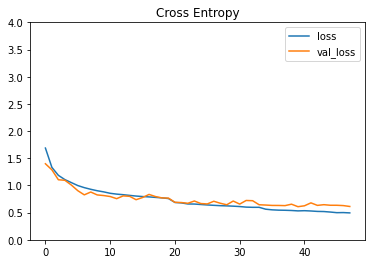

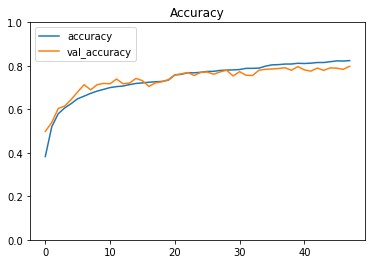

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=2)
history_df = pd.DataFrame(history.history)
loss_ax = history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross Entropy")
acc_ax = history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')
loss_ax.set_ylim(0, 4)
acc_ax.set_ylim(0, 1)